In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

In [3]:
# Định nghĩa hàm ACF và PACF :
def sACF(y,K):
    N=len(y)
    y_tb = y.mean()
    c0 = np.sum((y-y_tb)**2)/N
    ACF = np.zeros(K)
    for i in range (1,K+1):
        ck = np.sum((y-y_tb)[:N-i]*(y-y_tb)[i:N])/N
        ACF[i-1] = ck/c0
    se_ACF= np.zeros(K)
    for i in range (1,K+1):
        se_ACF[i-1] =  np.sqrt(1/N*(1+2*np.sum(ACF[:i]**2)))
    return ACF,se_ACF

def sPACF(y,K):
    N=len(y)
    ACF= sACF(y,K)[0]
    PACF = np.zeros(K)
    for m in range (1,K+1):
        P = np.eye(m)
        for i in range (m):
            for j in range (i):
                P[i,j]= ACF [i-j-1]
            for j in range (i+1,m):
                P[i,j] = ACF[j-i-1]
        PACF[m-1] =  np.linalg.solve(P,ACF[:m])[-1]
    se_PACF = np.array([1/np.sqrt(N) for i in range(K)])
    return PACF,se_PACF

In [4]:
data = pd.read_excel('chemical process.xlsx')
data.head()

,Temperature readings
0,26.6
1,27.0
2,27.1
3,27.1
4,27.1


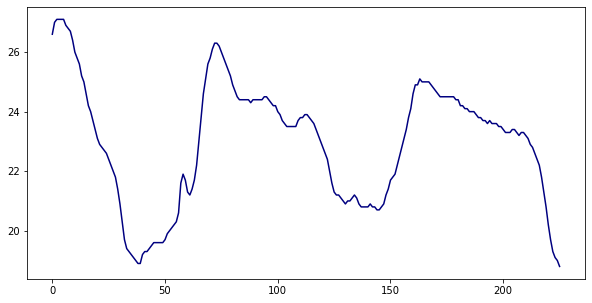

In [6]:
# Vẽ biểu đồ chuỗi chỉ số 
y = data['Temperature readings'].values
plt.subplots(figsize=(10,5))
plt.plot(y, color='navy')
plt.show()

In [13]:
# Thống kê mô tả cơ bản
n = len(y)
ytb = y.mean()
s_y = y.std() #do lech tieu chuan
print(f'n = {n},ytb = {ytb},s_y = {s_y}')

n = 226,ytb = 22.973893805309736,s_y = 2.054927138913887


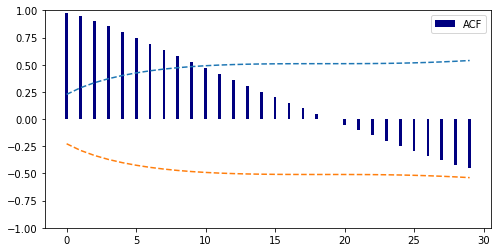

In [7]:
# Tính và vẽ biểu đổ ACF
K = 30
ACF, se_ACF =sACF(y,K)
# Vẽ đồ thị ACF 
fig,ax = plt.subplots(figsize=(8,4))
x = np.arange(K)
ax.bar(x,ACF,color='navy',width= 0.2, label = 'ACF')
ax.plot(x,2*se_ACF, linestyle ='dashed')
ax.plot(x,-2*se_ACF, linestyle ='dashed')
ax.set_ylim([-1,1])
ax.legend()

* Nhận xét : Hàm ACF giảm chậm và tuyến tính về 0, nên chuỗi tỉ giá là quá trình ko dừng => ta lấy sai phân chuỗi $ y_t$ và khảo sát tiếp

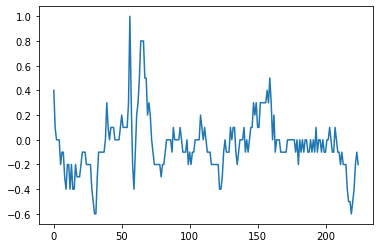

In [8]:
# Chuỗi sai phân
dy = np.diff(y)
plt.plot(dy)

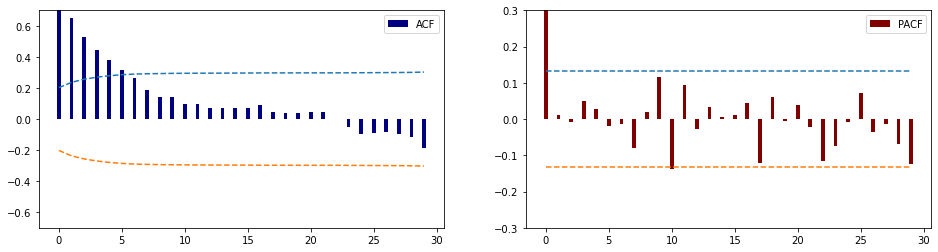

In [9]:
ACF, se_ACF = sACF(dy,K)
PACF, se_PACF = sPACF(dy,K)
# Vẽ đồ thị ACF 
fig,ax = plt.subplots(1,2,figsize=(16,4))
x = np.arange(K)
ax[0].bar(x,ACF,color='navy',width= 0.3, label = 'ACF')
ax[0].plot(x,2*se_ACF, linestyle ='dashed')
ax[0].plot(x,-2*se_ACF, linestyle ='dashed')
ax[0].set_ylim([-0.7,0.7])
ax[0].legend()

# Đồ thị PACF 
ax[1].bar(x, PACF, color = 'maroon', width = 0.3, label = 'PACF')
ax[1].plot(x,2*se_PACF, linestyle ='dashed')
ax[1].plot(x,-2*se_PACF, linestyle ='dashed')
ax[1].set_ylim([-0.3,0.3])
ax[1].legend()
plt.show()

 ### Nhận xét:
* Qua biểu đồ ACF, ta nhận thấy mô hình này giảm dần về 0 không phải theo tuyến tính. => ta có thể coi chuỗi sai phân này là dừng.


* Qua biểu đồ PACF, có 1 hệ số tự tương quan riêng đầu tiên khác 0 đáng kể, còn những hệ số tự tương quan riêng từ độ trễ k >1 coi bằng 0.
=> mô hình có thể phù hợp với dữ liệu này là AR(1)

In [25]:
# Ước lượng tham số AR(1)
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept = False)
ydata = dy[1:]
n=len(ydata)
X = np.vstack([np.ones(n),dy[:-1]]).T
model.fit(X,ydata)
print('Tham số beta:', model.coef_)
#Ước lượng sigma
at = ydata - model.predict(X)
sigma = np.sqrt(np.sum(at**2)/(len(at)-2))
# Sai số tiêu chuẩn của ước lượng tham số mô hình
se_param = sigma*np.sqrt(np.diag(np.linalg.inv(X.T@X)))
print('Sai số tiêu chuẩn của beta = ', se_param)

print('sigma =', sigma)
#Hiển thị dạng bảng 
df = pd.DataFrame(np.vstack([model.coef_,se_param]).T,
                 columns =['parameter','se(parameter)'])
df

Tham số beta: [-0.00921407  0.80737484]
Sai số tiêu chuẩn của beta =  [0.00905967 0.03882007]
sigma = 0.13415209536442554


,parameter,se(parameter)
0,-0.009214,0.00906
1,0.807375,0.03882


In [27]:
# Đánh giá mô hình bằng hệ số xác định R^2 va thống kê Q(k)
SE = np.sum(at**2)
ST = np.sum((ydata-ydata.mean())**2)
R2 = 1-SE/ST
print('SE = ', SE)
print('ST = ', ST)
print ('R^2= ',R2)

# Tính thống kê Q(k)
def Qstart(at,k):
    at_ACF =  sACF(at,k)[0]
    n=len(at)
    Qstart = 0
    for i in range(k):
        Qstart += n*(n+2)*at_ACF[i]**2/(n-i-1)
    return Qstart
k = 20
print('Giá trị thống kê Q(%d)= %f'%(k,Qstart(at,k)))

SE =  3.9952862013278363
ST =  11.779821428571433
R^2=  0.6608364375000246
Giá trị thống kê Q(20)= 22.813844
